<a href="https://colab.research.google.com/github/hhoppe/blackjack/blob/main/blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blackjack game probabilistic analysis

[Hugues Hoppe](https://hhoppe.com/) &emsp; first version in March 2022
&emsp;
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hhoppe/blackjack/blob/main/blackjack.ipynb)

(I was taking a reinforcement learning course which considered a simplified version of the blackjack game &mdash; *&ldquo;the most widely played casino banking game in the world&rdquo;* &mdash; this became a side project.)

**Goals**:

- Probabilistic analysis of
[blackjack](https://en.wikipedia.org/wiki/Blackjack) actions and outcomes
(without Monte Carlo simulation).

- Support for many rule variations, including:
  - Number of decks (1, 2, 4, 6, 8, infinite shoe)
  - Blackjack payout (e.g. 3:2, 6:5, 1:1)
  - Dealer stand/hit on soft total of 17
  - Loss of original bet or all bets to a dealer's blackjack.
  - Double on any two cards or with mininum total
  - Double after splitting (either any card or non-ace)
  - Resplit to any number of hands
  - Repslit aces

- Optimal-action tables for [basic strategy](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy) under any rules.

- Composition-dependent strategy (considering not just player total but individual card values).

- Computation of house edge under any rules, with either basic or composition-dependent strategy.

- Reproduction of the
[basic strategy tables](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy) and
[house edge results](https://en.wikipedia.org/wiki/Blackjack#Rule_variations_and_effects_on_house_edge)
listed in online sources.

**References**:
- https://en.wikipedia.org/wiki/Blackjack
- https://wizardofvegas.com/guides/blackjack-survey/
- https://www.onlinegambling.com/blackjack/odds/
- https://www.onlineunitedstatescasinos.com/las-vegas/blackjack/
- https://vegasadvantage.com/best-las-vegas-blackjack-games/

## Notes

- The term blackjack (abbreviated `bj`) refers to a natural (Ace, 10) hand
and not to any set of cards whose total is 21.

**TODO**:

- Run a simulation to precisely verify the negative house edge
   for `Rules(num_decks=1, stand_soft17=True)`.

## Imports

In [1]:
import dataclasses
import functools
import math
import re
from typing import Any, FrozenSet, Iterable, List
from typing import Mapping, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

In [2]:
Action = str  # 3.8: Literal['stand', 'hit', 'double', 'split', 'surrender']
Actions = FrozenSet[Action]
RecentCards = Tuple[int, ...]  # Empty tuple indicates no tracking of cards.

UNIFORM_CARD_PROB = {
    card: (4/13 if card == 10 else 1/13) for card in range(2, 12)}
ACTIONS = frozenset({'stand', 'hit', 'double', 'split', 'surrender'})
DISALLOWED = -1e10  # Large negative reward to prevent an action.

In [3]:
def check_eq(a: Any, b: Any) -> None:
  """Asserts that two values are equal."""
  if np.any(a != b):
    raise AssertionError(f'{a!r} == {b!r}')

In [4]:
def terse_str(cls):
  """Decorator for a dataclasses.dataclass, which defines a custom str()."""
  default_for_field = {
      f.name: (f.default_factory() if callable(f.default_factory)
               else f.default)
      for f in dataclasses.fields(cls)
  }

  def __str__(self):
    """Returns a string containing only the non-default field values."""
    s = ', '.join(f'{name}={getattr(self, name)!r}'
                  for name, default in default_for_field.items()
                  if getattr(self, name) != default)
    return f'{type(self).__name__}({s})'

  setattr(cls, '__str__', __str__)
  return cls

## Define `Rules`

The `Rules` class below captures the many
[variations in blackjack rules](https://en.wikipedia.org/wiki/Blackjack#Rule_variations_and_effects_on_house_edge).

The class fields default to values used in
the [Wikipedia page](https://en.wikipedia.org/wiki/Blackjack).

Another useful reference is a
[comparison of Las Vegas casinos](https://wizardofvegas.com/guides/blackjack-survey/)
which uses the base rules:
- BJ pays 3:2;
- one bet lost to a dealer’s BJ;
- you may double down on any two cards but not after splitting;
- you may split any pair;
- you may resplit any pair except aces to make up to four hands;
- split aces receive one card each;
- insurance;
- no surrender.

Those base rules correspond to
`Rules(double_after_split=False, late_surrender=False)`.

Their table of casinos (171 rows) lists common rule variations:
- "s17": (`stand_soft17=True`): 28 out of 171 (opposite of "h17").
- "ds": (`double_after_split=True`): 148 out of 171 (very frequent).
- "ls": (`late_surrender=True`): 56 out of 171.
- "rsa": (`resplit_aces=True`): 50 out of 171.

The casino listed with the lowest house edge is:
"Caesars Palace; 0.26%; 6 decks; s17,ds,ls,rsa". <br/>
This corresponds to `Rules(stand_soft17=True, resplit_aces=True)`.

In [5]:
@terse_str
@dataclasses.dataclass(frozen=True)
class Rules:
  """Blackjack rules.  There are many variations."""

  """Number of 52-card decks in the shoe, e.g., 1, 2, 4, 6, 8, or math.inf."""
  num_decks: float = 6

  """1.5 is standard; 6/5 or 1 greatly increase the house edge."""
  blackjack_payout: float = 1.5

  """Whether dealer hits or stands on a soft total of 17 ("s17"/"h17").
  True is favorable to player."""
  stand_soft17: bool = False

  """On dealer blackjack, lose Original Bet Only (not double or split).
  Often, the dealer begins by checking the hole card if showing 10 or ace."""
  obo: bool = True

  """Minimum player total for a "double" action.  Value 9 is the "Reno rule";
  value 10 is the "European rule"; value 0 allows double on any two cards."""
  double_min_total: int = 0  # 9:"Reno rule"; 10:"European"; 0:double_any.

  """Allows double as the first action of splitting a pair ("ds")."""
  double_after_split: bool = True  # "ds".

  """Allows the player to surrender, i.e. forfeit 50% of the bet if the dealer
  does not have blackjack ("ls")."""
  late_surrender: bool = True

  """Total number of hands that can result from splitting pairs.  Values include
  0 (no splitting), 2 (single split), 4, or math.inf."""
  split_to_num_hands: float = 4

  """Whether aces can be split more than once ("rsa")."""
  resplit_aces: bool = False

  """Allows hitting after splitting aces.  Usually a single card is added to
  each split ace and the player must stand."""
  hit_split_aces: bool = False

  """Allows doubling after splitting aces.  Rare."""
  double_split_aces: bool = False

  """Allows doubling with more than 2 cards.  Extremely rare."""
  double_after_hit: bool = False

## Define `Strategy`

In [6]:
@terse_str
@dataclasses.dataclass(frozen=True)
class Strategy:
  """Player's strategy."""

  """Consider the player's individual card values (not just their total).
  If False, use the "basic strategy" involving the total of card values."""
  composition_dependent: bool = False

  """Subset of player actions to consider; default is all actions."""
  actions: Actions = ACTIONS

## Functions

### Card totals

In [7]:
def combine_cards(card1: int, card2: int) -> Tuple[int, bool]:
  """Returns the total of two cards and whether that total is soft."""
  assert 2 <= card1 <= 11 and 2 <= card2 <= 11
  player_total = card1 + card2
  if player_total == 22:
    player_total = 12
  player_soft = card1 == 11 or card2 == 11
  return player_total, player_soft

In [8]:
def add_card(player_total: int, player_soft: bool,
             card: int) -> Tuple[int, bool]:
  """Returns a new total and softness state given an additional card."""
  assert 2 <= player_total <= 21 and 2 <= card <= 11
  player_total += card

  if card == 11:
    if player_total > 21:
      player_total -= 10
    else:
      player_soft = True

  if player_total > 21 and player_soft:
    player_total -= 10
    player_soft = False

  return player_total, player_soft

In [9]:
def two_cards_reproducing_total(player_total: int, player_soft: bool,
                                dealer_upcard: int) -> Tuple[int, int]:
  """Returns two cards to satisfy assertions (not used for probabilities)."""
  if player_soft:
    card1, card2 = 11, player_total - 11

  elif player_total >= 12:
    # The mode of the distribution has at least one card being a 10.
    card1, card2 = 10, player_total - 10

  else:
    # The mode of the distribution has both cards being distinct from dealer's,
    # so we prefer finding such two cards.
    for card1 in range(2, (player_total + 1) // 2):
      card2 = player_total - card1
      if dealer_upcard not in (card1, card2):
        break
    else:
      card1, card2 = 2, player_total - 2  # None preferable, so pick any two.

  return card1, card2

### Card probabilities

In [10]:
def card_probabilities(recent_cards: RecentCards,
                       rules: Rules) -> Mapping[int, float]:
  """Returns a mapping from card values (2-11) to their probabilities."""
  # Reduce memory usage by recognizing that num_decks is the only field used.
  return card_probabilities_helper(recent_cards, rules.num_decks)

In [11]:
@functools.lru_cache(maxsize=None)
def card_probabilities_helper(recent_cards: RecentCards,
                              num_decks: float) -> Mapping[int, float]:
  """Returns a mapping from card values (2-11) to their probabilities given
  some recently seen cards (e.g., player card1 and card2 and dealer upcard).
  (num_decks is of type float because it can be math.inf)."""
  if not recent_cards:
    return UNIFORM_CARD_PROB

  assert num_decks != math.inf
  # In a deck, there are 4 cards of each value, except 16 cards of value 10.
  count_of_card = {card: (16 if card == 10 else 4) * num_decks
                   for card in range(2, 12)}
  num_cards = num_decks * 52
  # If there are more recent cards of a given value than in the shoe, which
  # should not be possible, we ignore those extra cards.
  for card in recent_cards:
    if count_of_card[card] > 0:
      count_of_card[card] -= 1
      num_cards -= 1

  return {card: count / num_cards for card, count in count_of_card.items()}

In [12]:
def test_card_probabilities():
  check_eq(card_probabilities((3, 3, 3), Rules(num_decks=1))[3], 1 / 49)
  check_eq(card_probabilities((3, 3, 3, 3), Rules(num_decks=1))[3], 0)

test_card_probabilities()

In [13]:
@functools.lru_cache(maxsize=None)
def expected_num_split_hands(card1: int, recent_cards: RecentCards,
                             rules: Rules) -> float:
  """Returns the expected number of hands resulting from splitting pairs."""
  # There is the issue of whether one is allowed to split any two cards with
  # value 10, e.g. (Queen, Jack).  It is usually the case but may be disallowed.
  # It would affect the probability of occurrence of splits and resplits.
  # However, the optimal-actions tables show that is always favorable to
  # stand on 10-10, so the issue is moot.
  max_num_hands = (2 if card1 == 11 and not rules.resplit_aces
                   else rules.split_to_num_hands)
  if rules.num_decks == math.inf:
    return {
        2: 2.0,
        3: 2 + 2/13,  # 2.153_846
        4: 2 + 2/13 + 2/13*2/13,  # 2.177_515
        math.inf: 2 + 2/13/(1 - 2/13),  # 2.181_818
    }[max_num_hands]

  expected = 2.0
  if max_num_hands >= 3:
    prob3 = card_probabilities(recent_cards, rules)[card1]
    expected += 2 * prob3  # Each split brings two new cards.
  if max_num_hands >= 4:
    recent_cards2 = tuple(sorted(recent_cards + (card1,)))
    prob4 = card_probabilities(recent_cards2, rules)[card1]
    expected += (2 * prob3) * (2 * prob4)
  if max_num_hands >= 5:
    recent_cards3 = tuple(sorted(recent_cards2 + (card1,)))
    prob5 = card_probabilities(recent_cards3, rules)[card1]
    expected += (2 * prob3) * (2 * prob4) * (2 * prob5)
  # For now, limit the analysis to 5 hands.  The error is likely small.
  return expected

### Probability of dealer blackjack

In [14]:
def probability_dealer_bj(dealer_upcard: int, recent_cards: RecentCards,
                          rules: Rules) -> float:
  """Returns the probability that the dealer holds an (ace, 10)."""
  assert 2 <= dealer_upcard <= 11
  sum_prob = 0.0
  for card, prob in card_probabilities(recent_cards, rules).items():
    dealer_bj = dealer_upcard + card == 21
    sum_prob += prob * dealer_bj

  return sum_prob

In [15]:
def test_probability_dealer_bj_with_no_recent_cards():
  """Verify the card distribution given no knowledge of recent_cards."""
  recent_cards = ()
  for dealer_upcard in range(2, 12):
    check_eq(probability_dealer_bj(dealer_upcard, recent_cards, Rules()),
             (dealer_upcard == 11) * (4/13) + (dealer_upcard == 10) * (1/13))

test_probability_dealer_bj_with_no_recent_cards()

### Reward on dealer draw

In [16]:
@dataclasses.dataclass(frozen=True)
class DealerRules:
  """Subset of the `Rules` fields that apply to the dealer draw."""
  num_decks: float
  stand_soft17: bool
  obo: bool

In [17]:
def reward_after_dealer_upcard(
    player_total: int, dealer_upcard: int,
    recent_cards: RecentCards, rules: Rules) -> float:
  """Returns the expected reward after the player stands; assumes the player
  does not have bj; handles dealer bj if not OBO else ignores it."""
  # We extract DealerRules to improve the memoization efficiency of lru_cache.
  dealer_rules = DealerRules(
      num_decks=rules.num_decks, stand_soft17=rules.stand_soft17, obo=rules.obo)
  return reward_after_dealer_upcard_helper(
      player_total, dealer_upcard, recent_cards, dealer_rules)


In [18]:
@functools.lru_cache(maxsize=None)
def reward_after_dealer_upcard_helper(
    player_total: int, dealer_upcard: int,
    recent_cards: RecentCards, dealer_rules: DealerRules) -> float:
  """Returns the expected reward after the player stands; assumes the player
  does not have bj; handles dealer bj if not OBO else ignores it."""
  assert 4 <= player_total <= 32 and 2 <= dealer_upcard <= 11

  if player_total > 21:
    return -1.0  # Player busts and therefore loses.

  sum_reward = 0.0
  sum_prob = 0.0
  for card, prob in card_probabilities_helper(
      recent_cards, dealer_rules.num_decks).items():
    dealer_total, dealer_soft = combine_cards(dealer_upcard, card)
    dealer_bj = dealer_total == 21
    if dealer_bj:
      if dealer_rules.obo:
        pass  # dealer_bj already accounted for in reward_for_initial_action().
      else:
        sum_reward += prob * -1.0  # Dealer has blackjack and thus player loses.
        sum_prob += prob

    else:
      recent_cards2 = (tuple(sorted(recent_cards + (card,))) if recent_cards
                       else ())
      sum_reward += prob * reward_after_dealer_total(
          player_total, dealer_total, dealer_soft, recent_cards2, dealer_rules)
      sum_prob += prob

  return sum_reward / sum_prob

In [19]:
@functools.lru_cache(maxsize=None)
def reward_after_dealer_total(
    player_total: int, dealer_total: int, dealer_soft: bool,
    recent_cards: RecentCards, dealer_rules: DealerRules) -> float:
  """Returns expected reward after the player stands (given that neither
  player nor dealer has bj)."""
  assert 4 <= player_total <= 21 and 4 <= dealer_total <= 21

  dealer_hits = dealer_total < 17 or (
      dealer_total == 17 and dealer_soft and not dealer_rules.stand_soft17)
  if dealer_hits:
    sum_reward = 0.0
    for card, prob in card_probabilities_helper(
        recent_cards, dealer_rules.num_decks).items():
      dealer_total2, dealer_soft2 = add_card(dealer_total, dealer_soft, card)
      if dealer_total2 > 21:
        reward = 1.0  # Dealer busts and thus player wins.
      else:
        recent_cards2 = (tuple(sorted(recent_cards + (card,))) if recent_cards
                         else ())
        reward = reward_after_dealer_total(
            player_total, dealer_total2, dealer_soft2,
            recent_cards2, dealer_rules)
      sum_reward += prob * reward
    return sum_reward

  # Dealer stands.
  return (1.0 if player_total > dealer_total  # Player wins.
          else 0.0 if player_total == dealer_total  # Push; player gains zero.
          else -1.0)  # Player loses.

### Reward on initial player cards

In [20]:
def reward_for_initial_action(
    card1: int, card2: int, dealer_upcard: int,
    rules: Rules, strategy: Strategy, action: Action) -> float:
  """Compures the expected reward for the first action.
  Handles player blackjack, and if OBO, dealer blackjack as well.
  (If not OBO, dealer bj is handled in reward_after_dealer_upcard_helper().)"""
  player_bj = card1 + card2 == 21
  recent_cards = (() if rules.num_decks == math.inf else
                  tuple(sorted([card1, card2, dealer_upcard])))
  prob_dealer_bj = probability_dealer_bj(dealer_upcard, recent_cards, rules)

  if player_bj:
    if action != 'stand':
      return DISALLOWED
    reward = rules.blackjack_payout
    return (0.0 * prob_dealer_bj  # Push if both have blackjacks.
            + reward * (1.0 - prob_dealer_bj))  # Player bj wins.

  reward = reward_for_action(
      card1, card2, None, None, dealer_upcard, rules, strategy, action)

  if rules.obo:
    # Dealer blackjack beats any player hand, including 21, except player bj.
    # Player loses original bet only (obo) -- value 1.0.
    reward = -1.0 * prob_dealer_bj + reward * (1.0 - prob_dealer_bj)

  return reward

### Reward on player action

In [21]:
@functools.lru_cache(maxsize=None)
def reward_for_action(
    card1: int, card2: int, player_total: Optional[int],
    player_soft: Optional[bool], dealer_upcard: int,
    rules: Rules, strategy: Strategy, action: Action) -> float:
  """Returns the expected reward for either:
  - the first action (i.e., if player_total is None) (using card1 and card2) or
  - subsequent actions (using player_total and player_soft).
  The reward does not account for player blackjack (and if OBO, dealer
  blackjack)."""
  assert action in strategy.actions

  first_action = player_total is None
  if first_action:
    assert player_soft is None
    player_total, player_soft = combine_cards(card1, card2)

  assert player_total is not None and player_soft is not None
  assert 2 <= card1 <= 11 or card1 == 0
  assert 2 <= card2 <= 11 or card2 == 0
  assert 4 <= player_total <= 21
  recent_cards = (() if rules.num_decks == math.inf else
                  tuple(sorted(card for card in [card1, card2, dealer_upcard]
                               if card != 0)))

  if action == 'stand':
    return reward_after_dealer_upcard(
        player_total, dealer_upcard, recent_cards, rules)

  if action == 'hit':
    sum_reward = 0.0
    for card, prob in card_probabilities(recent_cards, rules).items():
      player_total2, player_soft2 = add_card(player_total, player_soft, card)
      if player_total2 > 21:
        reward = -1.0  # Player busts and loses.
      else:
        # Ideally, we would recursively update recent_cards, but this would
        # cause the lru_cache to become combinatorially large.
        reward = best_reward_and_action(
            card1, card2, player_total2, player_soft2, dealer_upcard,
            rules, strategy)[0]
      sum_reward += prob * reward
    return sum_reward

  if action == 'double':
    if not first_action and not rules.double_after_hit:
      return DISALLOWED
    if (rules.double_min_total > 0 and
        (player_soft or player_total < rules.double_min_total)):
      return DISALLOWED
    sum_reward = 0.0
    for card, prob in card_probabilities(recent_cards, rules).items():
      player_total2, player_soft2 = add_card(player_total, player_soft, card)
      recent_cards2 = (tuple(sorted(recent_cards + (card,))) if recent_cards
                       else ())
      # Player must 'stand' after 'double'.
      reward = reward_after_dealer_upcard(
          player_total2, dealer_upcard, recent_cards2, rules)
      sum_reward += prob * reward * 2.0
    return sum_reward

  if action == 'split':
    # The approach is to compute the expected number of split hands (due to
    # resplitting) and the expected reward per hand and multiply them.
    if not first_action or card1 != card2 or rules.split_to_num_hands == 0:
      return DISALLOWED
    num_split_hands = expected_num_split_hands(card1, recent_cards, rules)
    sum_reward = 0.0
    sum_prob = 0.0
    for card, prob in card_probabilities(recent_cards, rules).items():
      if num_split_hands > 2.0 and card == card1:
        # The resplit is already accounted for in num_split_hands.
        continue
      actions2 = strategy.actions - {'split', 'surrender'}
      if card1 == 11 and not rules.hit_split_aces:
        actions2 = actions2 - {'hit'}
      if (not rules.double_after_split or
          (card1 == 11 and not rules.double_split_aces)):
        actions2 = actions2 - {'double'}
      strategy2 = dataclasses.replace(strategy, actions=frozenset(actions2))
      reward = best_reward_and_action(
          card1, card, None, None, dealer_upcard, rules, strategy2)[0]
      sum_reward += prob * reward
      sum_prob += prob
    return sum_reward / sum_prob * num_split_hands

  if action == 'surrender':
    if not first_action:
      return DISALLOWED
    if rules.late_surrender:
      reward = -0.5  # Lose half the bet (unless dealer had bj).
      if rules.obo:
        pass  # dealer_bj already accounted for in reward_for_initial_action().
      else:
        prob_dealer_bj = probability_dealer_bj(
            dealer_upcard, recent_cards, rules)
        reward = -1.0 * prob_dealer_bj + reward * (1.0 - prob_dealer_bj)
      return reward
    return DISALLOWED

  raise AssertionError(action)

In [22]:
@functools.lru_cache(maxsize=None)
def best_reward_and_action(
    card1: int, card2: int, player_total: Optional[int],
    player_soft: Optional[bool], dealer_upcard: int,
    rules: Rules, strategy: Strategy,
    *, immediate_actions: Optional[Actions] = None) -> Tuple[float, Action]:
  """Determines the action with the best expected reward for either:
  - the first action (i.e., if player_total is None) (using card1 and card2) or
  - subsequent actions (using player_total and player_soft).
  Returns both the reward and action.
  
  Note that best_reward_and_action() evaluates the action rewards using
  reward_for_action() rather than reward_for_initial_action().
  Therefore, the computed rewards ignore player bj (and dealer bj if OBO).
  However, the ranking of the actions is unaffected, because the player bj
  (and dealer bj if OBO) are effectively handled before any user action.
  """
  immediate_actions = (
      strategy.actions if immediate_actions is None else immediate_actions)

  if not strategy.composition_dependent:
    # Compute the best action using the basic strategy.
    first_action = player_total is None
    player_total2, player_soft2 = player_total, player_soft
    if first_action:
      player_total2, player_soft2 = combine_cards(card1, card2)
    strategy2 = dataclasses.replace(strategy, composition_dependent=True)

    def action_allowed(action: Action) -> bool:
      """Determines if the action is allowed given all the parameters."""
      return reward_for_action(
          card1, card2, player_total, player_soft, dealer_upcard,
          rules, strategy2, action) != DISALLOWED

    args1 = (player_total2, player_soft2, dealer_upcard, rules, strategy)
    best_reward, best_action = max(
        (reward_for_basic_strategy_table(*args1, action), action)
        for action in immediate_actions - {'split'}
        if action_allowed(action))

    action = 'split'
    if (card1 == card2 and first_action and 'split' in immediate_actions and
        action_allowed(action)):
      reward = reward_for_action(
          card1, card2, None, None, dealer_upcard, rules, strategy, action)
      assert reward != DISALLOWED
      if (reward, action) > (best_reward, best_action):
        best_reward, best_action = reward, action

    # Using the basic-strategy best_action, compute the expected reward on
    # the specific (card1, card2) combination.
    best_reward = reward_for_action(
        card1, card2, player_total, player_soft, dealer_upcard,
        rules, strategy2, best_action)
    assert best_reward != DISALLOWED
    return best_reward, best_action

  args2 = (card1, card2, player_total, player_soft, dealer_upcard,
           rules, strategy)
  best_reward, best_action = max(
      (reward_for_action(*args2, action), action)
      for action in immediate_actions)
  return best_reward, best_action

### Reward for basic strategy

In [23]:
@functools.lru_cache(maxsize=None)
def reward_for_basic_strategy_table(
    player_total: int, player_soft: bool, dealer_upcard: int, rules: Rules,
    strategy: Strategy, action: Action) -> float:
  """Computes the per-action expected reward for each cell (player_total,
  dealer_upcard) of the two basic-strategy tables (player_soft=[False,True])."""
  assert not strategy.composition_dependent
  assert action != 'split'
  if player_total == 21:
    player_soft = True  # To allow a card to be a 11 (ace).

  # We compute the expected reward over all possible two dealt cards whose
  # total matches the specified total.  (The reward for each dealt cards is
  # evaluated using a composition-dependent analysis; otherwise the
  # evaluation would recurse infinitely.)
  strategy2 = dataclasses.replace(strategy, composition_dependent=True)
  sum_reward = 0.0
  sum_prob = 0.0
  recent_cards = (dealer_upcard,) if rules.num_decks != math.inf else ()

  for card1 in ((11,) if player_soft else
                range(max(2, player_total - 10),
                      min(10, player_total - 2) + 1)):
    prob1 = card_probabilities(recent_cards, rules)[card1]
    recent_cards2 = (tuple(sorted(recent_cards + (card1,))) if recent_cards
                     else ())
    card2 = 11 if player_soft and player_total == 12 else player_total - card1
    assert 2 <= card2 <= 11, (player_total, card1, card2)
    prob2 = card_probabilities(recent_cards2, rules)[card2]
    prob = prob1 * prob2
    reward = reward_for_action(
        card1, card2, None, None, dealer_upcard, rules, strategy2, action)
    sum_reward += prob * reward
    sum_prob += prob

  return sum_reward / sum_prob

### Basic-strategy tables

In [24]:
def action_tables_for_basic_strategy(
    rules: Rules, *, strategy: Strategy = Strategy()) -> List[np.ndarray]:
  """Returns a list of three 2D arrays:
  ((hard_player_total | soft_player_total | pair_value) vs dealer_upcard),
  whose cell values are the optimal action codes under the basic strategy."""
  assert not strategy.composition_dependent
  tables = []

  def code_from_actions(action0: Action, action1: Action) -> str:
    """Returns a short table cell label given an action and fallback action."""
    CODE_FROM_ACTION = {'stand': 'S', 'hit': 'H', 'double': 'D',
                        'split': 'SP', 'surrender': 'U'}
    s = CODE_FROM_ACTION[action0]
    if action0 != action1:
      s += CODE_FROM_ACTION[action1].lower()
    return s

  for player_soft in [False, True]:
    player_total_base = 13 if player_soft else 5
    shape = (22 - player_total_base, 10)  # (5-21, 2-11) or (13-21, 2-11)
    table = np.empty(shape, dtype=object)
    for player_total in range(player_total_base, 22):
      for dealer_upcard in range(2, 12):
        card1, card2 = two_cards_reproducing_total(
            player_total, player_soft, dealer_upcard)
        args1 = (card1, card2, None, None, dealer_upcard,
                 rules, strategy)
        action0 = best_reward_and_action(*args1)[1]
        fallback_actions = frozenset(strategy.actions & {'stand', 'hit'})
        action1 = best_reward_and_action(
            *args1, immediate_actions=fallback_actions)[1]
        table[player_total - player_total_base, dealer_upcard - 2] = (
            code_from_actions(action0, action1))
    tables.append(table)

  table = np.empty((10, 10), dtype=object)  # (2-11, 2-11)
  for card in range(2, 12):
    for dealer_upcard in range(2, 12):
      args2 = (card, card, None, None, dealer_upcard, rules, strategy)
      action0 = best_reward_and_action(*args2)[1]
      fallback_actions = frozenset(strategy.actions & {'stand', 'hit', 'split'})
      action1 = best_reward_and_action(
          *args2, immediate_actions=fallback_actions)[1]
      table[card - 2, dealer_upcard - 2] = code_from_actions(action0, action1)
  tables.append(table)

  return tables

In [25]:
def show_action_tables_for_basic_strategy(
    rules: Rules, *, strategy: Strategy = Strategy()):
  """Draws 3 tables of optimal actions for the basic strategy."""
  print(rules)
  print('Legend: (S)stand, (H)hit, (D)double, (SP)split, (U)surrender;'
        ' (Xy) means do X if allowed else Y.')
  tables = action_tables_for_basic_strategy(rules, strategy=strategy)
  COLOR_FOR_CODE = {
      'S': [1.0, 0.0, 0.0],  # Red.
      'H': [0.0, 1.0, 0.0],  # Green.
      'D': [0.0, 1.0, 1.0],  # Cyan.
      'SP': [1.0, 1.0, 0.0],  # Yellow.
      'U': [1.0, 1.0, 1.0],  # White.
  }
  gridspec = {'width_ratios': [1, 1, 1]}  # Same-width subplots.
  fig, axs = plt.subplots(1, 3, figsize=(12, 8), gridspec_kw=gridspec)

  def subplot(index: int, table: np.ndarray, title: str,
              yticklabels: Iterable[Any]):
    """Draws one of the 3 tables."""
    ax = axs[index]
    action_color = [[COLOR_FOR_CODE[re.sub(r'[a-z]*', '', a)] for a in row]
                    for row in table]
    ax.matshow(action_color)
    ny, nx = table.shape
    ax.hlines(y=np.arange(ny) + 0.5, xmin=-0.5, xmax=nx - 0.5, color='gray')
    ax.vlines(x=np.arange(nx) + 0.5, ymin=-0.5, ymax=ny - 0.5, color='gray')

    for yx in np.ndindex(table.shape):
      code = table[yx]
      ax.text(*yx[::-1], code, va='center', ha='center',
              fontsize=13, bbox=dict(alpha=0))

    ax.set_anchor('N')  # Align subplots at top (North).
    ax.set_ylim(ax.get_ylim()[::-1])  # Flip the vertical axis.
    ax.set_title(title, y=1.0, pad=10)
    ax.set_ylabel('Player total' if index == 0 else None)
    ax.set_xlabel('Dealer upcard')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_yticks(range(table.shape[0]))
    ax.set_xticks(range(table.shape[1]))
    ax.set_yticklabels(yticklabels)
    ax.set_xticklabels(range(2, 12))

  # Subplot (1) "Player total is hard" and Subplot (2) "Player total is soft".
  for index, player_soft in enumerate([False, True]):
    title = f'Player total is {"soft" if player_soft else "hard"}'
    player_total_base = 13 if player_soft else 5
    yticklabels: Iterable[Any] = range(player_total_base, 22)
    subplot(index, tables[index], title, yticklabels)

  # Subplot (3) "Player holds a pair".
  title = 'Player holds a pair'
  yticklabels = [f'{card},{card}' for card in range(2, 12)]
  subplot(2, tables[2], title, yticklabels)

  fig.tight_layout()
  plt.show()

In [26]:
def verify_action_tables(rules: Rules, expected: List[str]):
  """Test that the generated action tables reproduce the expected values."""
  tables = action_tables_for_basic_strategy(rules)
  for index, table in enumerate(tables):
    s = np.array2string(table, formatter=dict(all=lambda x: f'{x:3}'))
    check_eq(s, expected[index])

For testing, we define two sets of tables (`TEST_BASIC_STRATEGY_ACTION_{H,S}17`)
of the expected optimal actions using the basic strategy with the default rules.

In [27]:
#@title
"""Sanity check on expected result for "dealer hits on soft 17"."""
TEST_BASIC_STRATEGY_ACTION_H17 = [
    """[[H   H   H   H   H   H   H   H   H   H  ]
 [H   H   H   H   H   H   H   H   H   H  ]
 [H   H   H   H   H   H   H   H   H   H  ]
 [H   H   H   H   H   H   H   H   H   H  ]
 [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
 [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
 [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh ]
 [H   H   S   S   S   H   H   H   H   H  ]
 [S   S   S   S   S   H   H   H   H   H  ]
 [S   S   S   S   S   H   H   H   H   H  ]
 [S   S   S   S   S   H   H   H   Uh  Uh ]
 [S   S   S   S   S   H   H   Uh  Uh  Uh ]
 [S   S   S   S   S   S   S   S   S   Us ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]]""",
     """[[H   H   H   Dh  Dh  H   H   H   H   H  ]
 [H   H   H   Dh  Dh  H   H   H   H   H  ]
 [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
 [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
 [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
 [Ds  Ds  Ds  Ds  Ds  S   S   H   H   H  ]
 [S   S   S   S   Ds  S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]]""",
     """[[SP  SP  SP  SP  SP  SP  H   H   H   H  ]
 [SP  SP  SP  SP  SP  SP  H   H   H   H  ]
 [H   H   H   SP  SP  H   H   H   H   H  ]
 [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
 [SP  SP  SP  SP  SP  H   H   H   H   H  ]
 [SP  SP  SP  SP  SP  SP  H   H   H   H  ]
 [SP  SP  SP  SP  SP  SP  SP  SP  SP  Usp]
 [SP  SP  SP  SP  SP  S   SP  SP  S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [SP  SP  SP  SP  SP  SP  SP  SP  SP  SP ]]""",
]

"""Sanity check on expected result for "dealer stands on soft 17"."""
TEST_BASIC_STRATEGY_ACTION_S17 = [
    """[[H   H   H   H   H   H   H   H   H   H  ]
 [H   H   H   H   H   H   H   H   H   H  ]
 [H   H   H   H   H   H   H   H   H   H  ]
 [H   H   H   H   H   H   H   H   H   H  ]
 [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
 [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
 [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H  ]
 [H   H   S   S   S   H   H   H   H   H  ]
 [S   S   S   S   S   H   H   H   H   H  ]
 [S   S   S   S   S   H   H   H   H   H  ]
 [S   S   S   S   S   H   H   H   Uh  H  ]
 [S   S   S   S   S   H   H   Uh  Uh  Uh ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]]""",
     """[[H   H   H   Dh  Dh  H   H   H   H   H  ]
 [H   H   H   Dh  Dh  H   H   H   H   H  ]
 [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
 [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
 [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
 [S   Ds  Ds  Ds  Ds  S   S   H   H   H  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]]""",
     """[[SP  SP  SP  SP  SP  SP  H   H   H   H  ]
 [SP  SP  SP  SP  SP  SP  H   H   H   H  ]
 [H   H   H   SP  SP  H   H   H   H   H  ]
 [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
 [SP  SP  SP  SP  SP  H   H   H   H   H  ]
 [SP  SP  SP  SP  SP  SP  H   H   H   H  ]
 [SP  SP  SP  SP  SP  SP  SP  SP  SP  SP ]
 [SP  SP  SP  SP  SP  S   SP  SP  S   S  ]
 [S   S   S   S   S   S   S   S   S   S  ]
 [SP  SP  SP  SP  SP  SP  SP  SP  SP  SP ]]""",
]

## Table of actions for basic strategy

In blackjack, **basic strategy** refers to using some optimal-action tables based on the dealer's upcard, the total of the player cards, and whether the player total is hard or soft.  The basic strategy does not consider the particular card values that contribute to the player total.

### Dealer hits on soft 17 (unfavorable)

Here we use the default of 6 decks.  The optimal actions exactly match those in the *basic strategy* tables shown in [Wikipedia](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy).

Rules()
Legend: (S)stand, (H)hit, (D)double, (SP)split, (U)surrender; (Xy) means do X if allowed else Y.


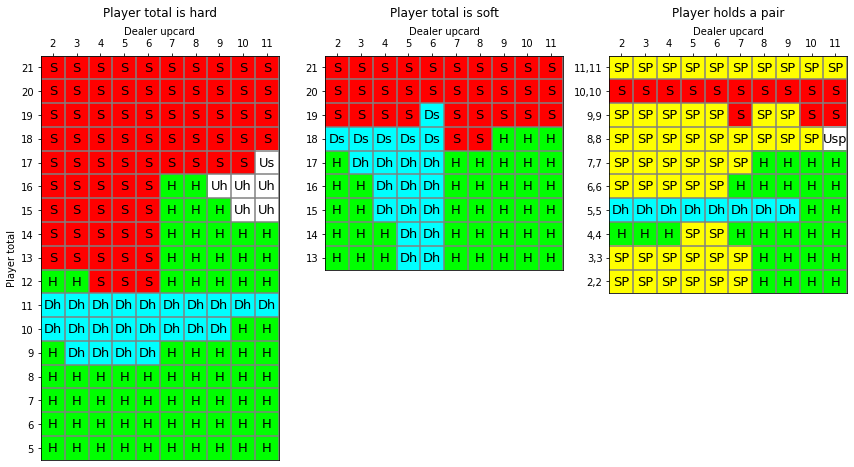

In [28]:
show_action_tables_for_basic_strategy(Rules())
verify_action_tables(Rules(), expected=TEST_BASIC_STRATEGY_ACTION_H17)

### Dealer stands on soft 17 (favorable)

We now consider the case where the dealer must **stand on a soft 17**, still with the default of 6 decks.  This results in the optimal actions changing for **6 cells**, in agreement with the description in [Wikipedia](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy):

"only 6 cells are changed: hit on 11 vs. A, hit on 15 vs. A, stand on 17 vs. A, stand on A,7 vs. 2, stand on A,8 vs. 6, and split on 8,8 vs. A".

Rules(stand_soft17=True)
Legend: (S)stand, (H)hit, (D)double, (SP)split, (U)surrender; (Xy) means do X if allowed else Y.


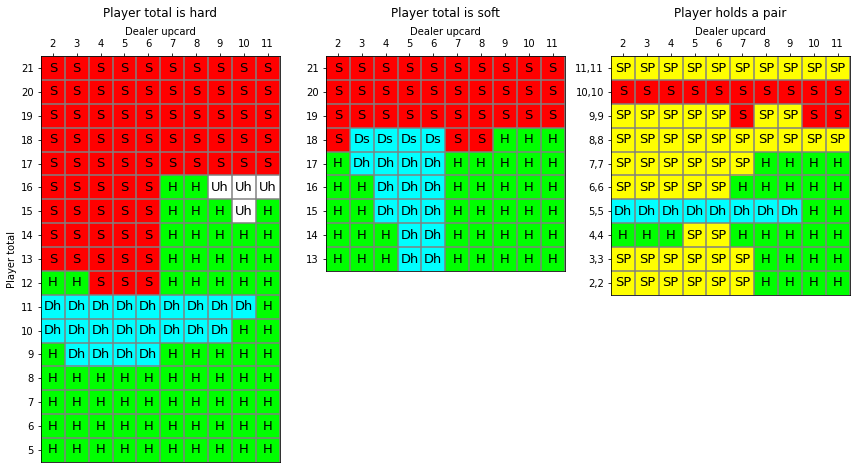

In [29]:
show_action_tables_for_basic_strategy(Rules(stand_soft17=True))
verify_action_tables(
    Rules(stand_soft17=True), expected=TEST_BASIC_STRATEGY_ACTION_S17)

In [30]:
check_eq([np.argwhere(table1 != table2).tolist() for table1, table2 in zip(
    action_tables_for_basic_strategy(Rules()),
    action_tables_for_basic_strategy(Rules(stand_soft17=True)))],
    [[[6, 9], [10, 9], [12, 9]], [[5, 0], [6, 4]], [[6, 9]]])

### Varying the number of decks

The basic strategy varies with the number of decks, because the probability of drawing 10s or Aces changes slightly after the 3 dealt cards.

- The same actions computed above for 6 decks are also optimal across 4 to 8 decks, as documented in Wikipedia:

In [31]:
verify_action_tables(
    Rules(num_decks=4), expected=TEST_BASIC_STRATEGY_ACTION_H17)
verify_action_tables(
    Rules(num_decks=8), expected=TEST_BASIC_STRATEGY_ACTION_H17)

- If using a single deck, many optimal actions change.
In fact, 14 (5 + 4 + 2) table cells differ:

Rules(num_decks=1)
Legend: (S)stand, (H)hit, (D)double, (SP)split, (U)surrender; (Xy) means do X if allowed else Y.


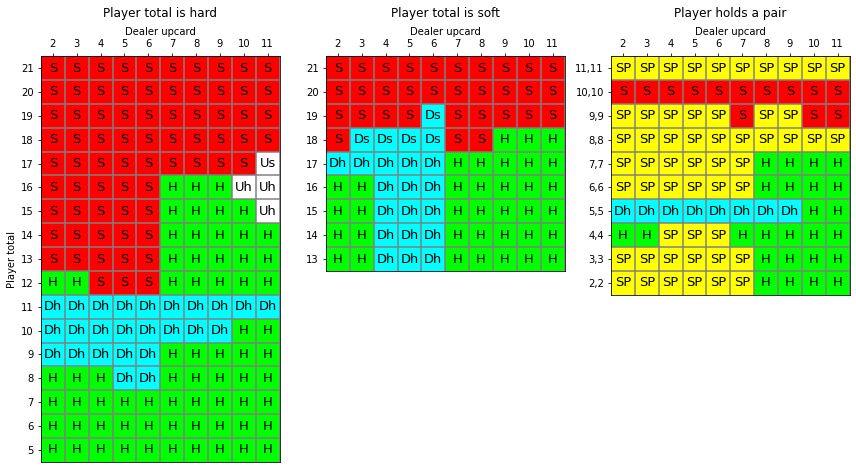

In [32]:
show_action_tables_for_basic_strategy(Rules(num_decks=1))

In [33]:
check_eq([np.count_nonzero(table1 != table2) for table1, table2 in zip(
    action_tables_for_basic_strategy(Rules(num_decks=6)),
    action_tables_for_basic_strategy(Rules(num_decks=1)))],
    [5, 4, 3])

- When moving from 4-8 decks to an infinite shoe, a single cell changes: 'soft13 vs 5' changes from `Dh` to `H`:

In [34]:
if 0:
  show_action_tables_for_basic_strategy(Rules(num_decks=math.inf))

check_eq([np.argwhere(table1 != table2).tolist() for table1, table2 in zip(
    action_tables_for_basic_strategy(Rules()),
    action_tables_for_basic_strategy(Rules(num_decks=math.inf)))],
    [[], [[0, 3]], []])
check_eq(action_tables_for_basic_strategy(Rules())[1][0, 3], 'Dh')
check_eq(action_tables_for_basic_strategy(Rules(num_decks=math.inf))[1][0, 3],
         'H')

## Composition-dependent strategy

For a small number of decks, it is slightly beneficial to consider the
individual card values `(card1, card2)`
rather than `(player_total, player_soft)` to determine the best action.

From Wikipedia: "For example, players should ordinarily stand when holding 12 against a dealer 4. But in a single deck game, players should hit if their 12 consists of a 10 and a 2."

In [35]:
def show_differences_using_composition_dependent_strategy(rules: Rules):
  """Finds the card values where a composition-dependent strategy has
  optimal actions that differ from the basic strategy."""
  for index, num_decks in enumerate([6, 4, 2, 1]):
    new_rules = dataclasses.replace(rules, num_decks=num_decks)
    newline = '\n' if index > 0 else ''
    print(f'{newline}* For num_decks={num_decks}:')
    print('  card1  card2  dealer_up  basic_strategy  composition_dependent')
    bs_strategy = Strategy()
    cd_strategy = Strategy(composition_dependent=True)
    for card1 in range(2, 12):
      for card2 in range(card1, 12):  # Ignore (redundant) card2 < card1.
        for dealer_upcard in range(2, 12):
          bs_action = best_reward_and_action(
            card1, card2, None, None, dealer_upcard, new_rules, bs_strategy)[1]
          cd_action = best_reward_and_action(
            card1, card2, None, None, dealer_upcard, new_rules, cd_strategy)[1]
          if bs_action != cd_action:
            print(f'   {card1:2} {card2:6} {dealer_upcard:8}'
                  f'        {bs_action:^9}         {cd_action:^9}')


show_differences_using_composition_dependent_strategy(Rules())

* For num_decks=6:
  card1  card2  dealer_up  basic_strategy  composition_dependent
    7      8       10        surrender            hit   

* For num_decks=4:
  card1  card2  dealer_up  basic_strategy  composition_dependent
    7      8       10        surrender            hit   

* For num_decks=2:
  card1  card2  dealer_up  basic_strategy  composition_dependent
    4      8        3           hit              stand  
    5      7        3           hit              stand  
    6      6        7           hit              split  
    7      7        8           hit              split  
    7      8       10        surrender            hit   
    7      8       11        surrender            hit   

* For num_decks=1:
  card1  card2  dealer_up  basic_strategy  composition_dependent
    2      6        6         double              hit   
    2     10        4          stand              hit   
    3      9        3           hit              stand  
    3     10        2          sta

## House edge

The "house edge" is the fraction of the action lost over
the long run.  Thus it is the negative of the expected reward.

Wikipedia: "Most blackjack games have a house edge of between 0.5% and 1%".

In [36]:
def house_edge(rules: Rules, *, strategy: Strategy = Strategy()) -> float:
  """Returns the 'house edge', which is the expected player loss (as a fraction
  of the initial bet).  It is the negative of the average reward."""
  sum_reward = 0.0
  recent_cards0 = ()
  # Compute the expected reward over all possible 3 dealt cards.
  for card1, prob1 in card_probabilities(recent_cards0, rules).items():
    recent_cards1 = () if rules.num_decks == math.inf else (card1,)
    for card2, prob2 in card_probabilities(recent_cards1, rules).items():
      recent_cards2 = (() if rules.num_decks == math.inf
                       else tuple(sorted([card1, card2])))
      for dealer_upcard, prob3 in card_probabilities(
          recent_cards2, rules).items():
        prob = prob1 * prob2 * prob3
        best_action = best_reward_and_action(
            card1, card2, None, None, dealer_upcard, rules, strategy)[1]
        reward = reward_for_initial_action(
            card1, card2, dealer_upcard, rules, strategy, best_action)
        sum_reward += prob * reward

  return -sum_reward

In [37]:
def report_house_edge(rules: Rules, strategy: Strategy = Strategy(),
                      expected: Optional[float] = None):
  """Prints the house edge and optionally compares it with an expected value."""
  print(rules, strategy)
  house_edge_percent = house_edge(rules, strategy=strategy) * 100
  print(f'House edge: {house_edge_percent:.3f}%')
  if expected is not None:
    assert abs(house_edge_percent - expected) < 0.02, house_edge_percent

### Common casino rules

The default in `Rules` is that the dealer hits on a soft 17.

In [38]:
report_house_edge(Rules(), expected=0.528)

Rules() Strategy()
House edge: 0.528%


Some low house edges from https://wizardofvegas.com/guides/blackjack-survey/
include:

- Caesars Palace Casino; 0.26%; 6 decks; "s17,ds,ls,rsa"
- Cosmopolitan Casino;   0.28%; 8 decks; "s17,ds,ls,rsa":

The results computed here (0.260% and 0.281%) are a precise match:

In [39]:
report_house_edge(Rules(num_decks=6, stand_soft17=True, resplit_aces=True),
                  expected=0.26)
report_house_edge(Rules(num_decks=8, stand_soft17=True, resplit_aces=True),
                  expected=0.28)

Rules(stand_soft17=True, resplit_aces=True) Strategy()
House edge: 0.260%
Rules(num_decks=8, stand_soft17=True, resplit_aces=True) Strategy()
House edge: 0.281%


A larger house edge is:
- Mirage Casino; 0.49%; 8 decks; "h17,ds,ls,rsa":

The result computed here (0.481%) is a close match:

In [40]:
report_house_edge(Rules(num_decks=8, stand_soft17=False, resplit_aces=True),
                  expected=0.48)

Rules(num_decks=8, resplit_aces=True) Strategy()
House edge: 0.481%


### Extreme rules and strategies

Here we consider the best rules and strategies (i.e., most favorable to the player), as well as the worst ones.

In the rosiest scenario (not offered in any casino), the player would only gain 0.4% of the initial bet,
on average.

With the most house-friendly rules and restricting the player actions to just `{'hit', 'stand'}`, the house edge increases to about 5%.
Realistically, an average player may not carefully follow the basic strategy and therefore might do even worse.

In [41]:
BEST_RULES = Rules(
    num_decks=1, split_to_num_hands=math.inf, resplit_aces=True,
    hit_split_aces=True, double_split_aces=True, double_after_hit=True)
WORST_RULES = Rules(
    num_decks=math.inf, blackjack_payout=1, stand_soft17=True, obo=False,
    double_min_total=10, double_after_split=False, late_surrender=False,
    split_to_num_hands=2)

In [42]:
BEST_STRATEGY = Strategy(composition_dependent=True)
WORST_STRATEGY = Strategy(actions=frozenset({'stand', 'hit'}))

In [43]:
report_house_edge(BEST_RULES, strategy=BEST_STRATEGY, expected=-0.42)
report_house_edge(WORST_RULES, strategy=WORST_STRATEGY, expected=4.68)

Rules(num_decks=1, split_to_num_hands=inf, resplit_aces=True, hit_split_aces=True, double_split_aces=True, double_after_hit=True) Strategy(composition_dependent=True)
House edge: -0.419%
Rules(num_decks=inf, blackjack_payout=1, stand_soft17=True, obo=False, double_min_total=10, double_after_split=False, late_surrender=False, split_to_num_hands=2) Strategy(actions=frozenset({'hit', 'stand'}))
House edge: 4.676%


### Dependence on number of decks

In [44]:
def analyze_number_of_decks(rules: Rules, **kwargs: Any):
  """Tabulates the house edge as a function of the number of decks."""
  print(rules)
  print('Number of decks     House edge %')
  for num_decks in [1, 2, 4, 6, 8, 20, math.inf]:
    new_rules = dataclasses.replace(rules, num_decks=num_decks)
    edge = house_edge(new_rules, **kwargs)
    print(f'{num_decks:8}{edge*100: 20.3f}')

Wikipedia gives house edge results for various numbers of decks (given the rules
"double after split allowed, resplit to four hands allowed, no hitting split aces, no surrender,
double on any two cards, original bets only lost on dealer blackjack, dealer hits soft 17, and cut-card used"):

| Number of decks | House edge % |
|:---:|:---:|
| 1 | 0.17% |
| 2 | 0.46% |
| 4 | 0.60% |
| 6 | 0.64% |
| 8 | 0.66% |

We obtain results with a similar pattern showing that the house edge is much diminished when the number of decks is reduced to 1.
The numbers are slightly off (why?).

It is surprising that 8 decks is still quite different from an infinite shoe:

In [45]:
print(repr(Rules(late_surrender=False)))
analyze_number_of_decks(Rules(late_surrender=False))

Rules(num_decks=6, blackjack_payout=1.5, stand_soft17=False, obo=True, double_min_total=0, double_after_split=True, late_surrender=False, split_to_num_hands=4, resplit_aces=False, hit_split_aces=False, double_split_aces=False, double_after_hit=False)
Rules(late_surrender=False)
Number of decks     House edge %
       1               0.025
       2               0.383
       4               0.557
       6               0.615
       8               0.644
      20               0.695
     inf               0.729


With a single deck (and the default `late_surrender=True`), 
the house edge happens to lie very close to zero:

In [46]:
report_house_edge(Rules(num_decks=1), expected=0.0)

Rules(num_decks=1) Strategy()
House edge: 0.002%


With a single deck and the rule "dealer stands on soft17", the house edge is negative:

In [47]:
report_house_edge(Rules(num_decks=1, stand_soft17=True), expected=-0.18)

Rules(num_decks=1, stand_soft17=True) Strategy()
House edge: -0.177%


### Subset of player actions

In [48]:
def analyze_subset_of_player_actions(rules: Rules):
  """Tabulates the house edge as a function of the subset of player actions."""
  print(rules)
  print('Subset of player actions        House edge %')
  for actions in [ACTIONS,
                  {'stand', 'hit', 'double', 'split'},
                  {'stand', 'hit', 'double'},
                  {'stand', 'hit', 'split'},
                  {'stand', 'hit'}]:
    edge = house_edge(rules, strategy=Strategy(actions=frozenset(actions)))
    name = ('default' if actions == ACTIONS
            else f'only {"/".join(sorted(actions))}')
    print(f' {name:32} {edge*100: .3f}')

We see that omitting the "surrender" action only increases the house edge by about 0.09%.

In contrast, omitting either the "double" or "split" actions significantly increases the house edge.

Restricting the strategy to only making the binary "stand or hit" decision boosts the house edge to more than 2.5% :

In [49]:
analyze_subset_of_player_actions(Rules())

Rules()
Subset of player actions        House edge %
 default                           0.528
 only double/hit/split/stand       0.615
 only double/hit/stand             1.177
 only hit/split/stand              2.137
 only hit/stand                    2.557


### Rule variations

In [50]:
def analyze_rule_variations(rules: Rules):
  """Computes the effect of rule variations on the house edge."""
  print(rules)
  print(f'Default house edge: {house_edge(rules)*100:.3f}%')
  print('Rule variation                  Edge change   Wikipedia')
  edge0 = house_edge(rules)

  def f(name: str, expected: str = '', **variation: Any):
    """Considers a particular rule variation."""
    modified_rules = dataclasses.replace(rules, **variation)
    edge = house_edge(modified_rules)
    edge_change_in_percent = (edge - edge0) * 100
    s_expected = f'      {expected}' if expected else ''
    print(f' {name:32} {edge_change_in_percent:+.3f}  {s_expected}')

  # Casino promotions such as 2:1 bj allow the player to acquire an advantage.
  f('blackjack payout 2/1', blackjack_payout=2/1)

  # "the 6:5 game adds 1.4% to the house edge"
  f('blackjack payout 6/5', blackjack_payout=6/5, expected='+1.4')

  # "the 1:1 game increases the house edge by 2.3%"
  f('blackjack payout 1/1', blackjack_payout=1/1, expected='+2.3')

  # "decreases the house edge by about 0.2%"
  f('dealer stands soft 17', stand_soft17=True, expected='-0.2')

  # "The no hole card rule adds approximately 0.11% to the house edge."
  f('no hole card (no OBO)', obo=False, expected='+0.11')

  # "Reno rule increases the house edge by around 0.1%"
  f('min 9 for double (Reno)', double_min_total=9, expected='+0.1')

  # "European version increases the house edge by around 0.2%"
  f('min 10 for double (European)', double_min_total=10, expected='+0.2')

  # "Disallowing doubling after a split increases the house edge by about 0.12%"
  f('no double after split', double_after_split=False, expected='+0.12')

  # Surrender disallowed.  (We never allow "early surrender".)
  f('no surrender', late_surrender=False)

  # Splits are never allowed.
  f('no splitting', split_to_num_hands=0)

  # No more than one split allowed.
  f('no resplitting', split_to_num_hands=2)

  # No more than two splits allowed.
  f('resplit only to 3 hands', split_to_num_hands=3)

  # Any number of splits allowed.
  f('unlimited resplit', split_to_num_hands=math.inf)

  # "allowing resplitting of aces reduces house edge by about 0.03%"
  f('resplit aces', resplit_aces=True, expected='-0.03')

  # "hit hands resulting from split aces reduces the house edge by about 0.13%"
  f('hit after split aces', hit_split_aces=True, expected='-0.13')

  #
  f('double after split aces', double_split_aces=True)

  # Doubles are usually allowed only as initial action or sometimes after split.
  f('double after hit', double_after_hit=True)

The effects for most rule variations agree well with those in Wikipedia,
except for two (`resplit_aces=True` and `hit_split_aces=True`) (why?).

In [51]:
analyze_rule_variations(Rules())

Rules()
Default house edge: 0.528%
Rule variation                  Edge change   Wikipedia
 blackjack payout 2/1             -2.266  
 blackjack payout 6/5             +1.360        +1.4
 blackjack payout 1/1             +2.266        +2.3
 dealer stands soft 17            -0.198        -0.2
 no hole card (no OBO)            +0.105        +0.11
 min 9 for double (Reno)          +0.105        +0.1
 min 10 for double (European)     +0.199        +0.2
 no double after split            +0.142        +0.12
 no surrender                     +0.087  
 no splitting                     +0.555  
 no resplitting                   +0.054  
 resplit only to 3 hands          +0.001  
 unlimited resplit                -0.000  
 resplit aces                     -0.070        -0.03
 hit after split aces             -0.178        -0.13
 double after split aces          -0.079  
 double after hit                 -0.226  


When disallowing resplitting, the effect of "no double after split" (0.12%) exactly matches that reported in Wikipedia, so perhaps this was the context of that reported number:

In [52]:
analyze_rule_variations(Rules(split_to_num_hands=2))

Rules(split_to_num_hands=2)
Default house edge: 0.582%
Rule variation                  Edge change   Wikipedia
 blackjack payout 2/1             -2.266  
 blackjack payout 6/5             +1.360        +1.4
 blackjack payout 1/1             +2.266        +2.3
 dealer stands soft 17            -0.197        -0.2
 no hole card (no OBO)            +0.103        +0.11
 min 9 for double (Reno)          +0.104        +0.1
 min 10 for double (European)     +0.197        +0.2
 no double after split            +0.122        +0.12
 no surrender                     +0.087  
 no splitting                     +0.501  
 no resplitting                   +0.000  
 resplit only to 3 hands          -0.053  
 unlimited resplit                -0.054  
 resplit aces                     +0.000        -0.03
 hit after split aces             -0.178        -0.13
 double after split aces          -0.079  
 double after hit                 -0.227  


### Composition-dependent strategy

In [53]:
def analyze_composition_dependent_strategy_with_number_of_decks(rules: Rules):
  """Shows it reduces the house edge slightly with a small number of decks."""
  print(f'House edge % using {rules}:')
  print(' Number of decks   Basic strategy   Composition-dependent   Change')
  for num_decks in [1, 2, 4, 6, math.inf]:
    modified_rules = dataclasses.replace(rules, num_decks=num_decks)
    basic_strategy_house_edge = house_edge(modified_rules, strategy=Strategy())
    composition_dependent_house_edge = house_edge(
        modified_rules, strategy=Strategy(composition_dependent=True))
    change = composition_dependent_house_edge - basic_strategy_house_edge
    print(f'{num_decks:8} {basic_strategy_house_edge*100:20.3f}'
          f' {composition_dependent_house_edge*100:18.3f} {change*100:17.4f}')

From Wikipedia,
"Using a composition-dependent strategy rather than basic strategy in a single deck game reduces the house edge by 4 in 10,000 (0.04%), which falls to 3 in 100,000 (0.003%) for a six-deck game."

In our results, the single deck game increases the house edge by 0.03% (rather than 0.04%), and the six-deck game increases it by 0.002% rather than 0.003%.
It does not match exactly but is very close:

In [54]:
analyze_composition_dependent_strategy_with_number_of_decks(Rules())

House edge % using Rules():
 Number of decks   Basic strategy   Composition-dependent   Change
       1                0.002             -0.027           -0.0285
       2                0.325              0.314           -0.0105
       4                0.478              0.475           -0.0033
       6                0.528              0.526           -0.0015
     inf                0.627              0.627            0.0000


Here is a similar comparison when the dealer stands on a soft total of 17:

In [55]:
analyze_composition_dependent_strategy_with_number_of_decks(
    Rules(stand_soft17=True))

House edge % using Rules(stand_soft17=True):
 Number of decks   Basic strategy   Composition-dependent   Change
       1               -0.177             -0.208           -0.0307
       2                0.137              0.126           -0.0112
       4                0.283              0.279           -0.0034
       6                0.330              0.328           -0.0015
     inf                0.424              0.424            0.0000


## Effect of cut-card

A cut-card is often added to the shoe (e.g. 0.5 to 2.0 decks from the back), and the shoe is reshuffled after the cut-card is reached.
There are
[claims](https://www.blackjackincolor.com/blackjackeffects1.htm)
that the presence of the cut-card increases the house edge.
However, those claims seem unconvincing to me.

My reasoning, which closely matches
[this discussion](https://wizardofvegas.com/forum/gambling/blackjack/31457-cut-card-effect/),
is that if the subset of cards in front of the cut-card has more tens than average, then the dealt hands involve fewer cards and more hands are played
using those cards (relative to the case that the cards have fewer tens than average).
Because hands with tens are favorable to the player, this should *reduce* the house edge.  This is a mild effect related to "card counting" but done implicitly.

## End

In [56]:
TEST_RULES = Rules(
    num_decks=1, blackjack_payout=1, stand_soft17=True, obo=False,
    double_min_total=9, double_after_split=False, late_surrender=False,
    split_to_num_hands=3, resplit_aces=True, hit_split_aces=True,
    double_split_aces=True, double_after_hit=True)

In [57]:
import IPython
import pandas

In [58]:
def pandas_analyze_number_of_decks(rules: Rules, **kwargs: Any):
  """Try using pandas to output a table."""
  print(rules)
  table = []
  for num_decks in [1, 2, 4, 6, 8, 20, math.inf]:
    new_rules = dataclasses.replace(rules, num_decks=num_decks)
    edge = house_edge(new_rules, **kwargs)
    table.append([num_decks, edge * 100])
  df = pandas.DataFrame(table, columns=['Number of decks', 'House edge %'])
  if 0:
    formatters = {'Number of decks': '{:.0f}'.format,
                  'House edge %': '{:.3f}%'.format}
    html = df.to_html(index=False, formatters=formatters, justify='center')
    # Problem: it only centers the column headers, not the data cells.
    IPython.display.display(IPython.display.HTML(html))
  else:
    styler = df.style.set_properties(**{'text-align': 'center'})
    styler.hide_index()  # https://stackoverflow.com/a/40993135
    styler.format({'Number of decks': '{:.0f}', 'House edge %': '{:.3f}%'})
    IPython.display.display(styler)


pandas_analyze_number_of_decks(Rules())

Rules()


Number of decks,House edge %
1,0.002%
2,0.325%
4,0.478%
6,0.528%
8,0.553%
20,0.598%
inf,0.627%
